<a href="https://colab.research.google.com/github/longhai2003/Timeseries/blob/main/TH2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import pandas as pd

In [51]:
file_path = "/content/pjme_daily_hmm.csv"
df = pd.read_csv(file_path, parse_dates=['Datetime'])

In [52]:
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6059 entries, 0 to 6058
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Datetime       6059 non-null   datetime64[ns]
 1   PJME_MW        6059 non-null   float64       
 2   State          6059 non-null   int64         
 3   Energy_Scaled  6059 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 189.5 KB


(None,
     Datetime       PJME_MW  State  Energy_Scaled
 0 2002-01-01  31080.739130      2      -0.213245
 1 2002-01-02  34261.541667      2       0.465529
 2 2002-01-03  34511.875000      2       0.518950
 3 2002-01-04  33715.458333      2       0.348997
 4 2002-01-05  30405.125000      2      -0.357419)

In [53]:
df_daily = df.set_index('Datetime').resample('D').mean().dropna()

energy_values = df_daily['PJME_MW'].values

df_daily.head()


,PJME_MW,State,Energy_Scaled
Datetime,,,
2002-01-01,31080.739130,2.0,-0.213245
2002-01-02,34261.541667,2.0,0.465529
2002-01-03,34511.875000,2.0,0.518950
2002-01-04,33715.458333,2.0,0.348997
2002-01-05,30405.125000,2.0,-0.357419


#Huấn luyện mô hình HMM

Chuẩn hóa dữ liệu

In [54]:
pip install hmmlearn

In [55]:
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
import numpy as np

scaler = StandardScaler()
energy_scaled = scaler.fit_transform(energy_values.reshape(-1, 1))

n_states = 3
hmm_model = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=1000, random_state=42)
hmm_model.fit(energy_scaled)

hidden_states = hmm_model.predict(energy_scaled)

df_daily['State'] = hidden_states
df_daily['Energy_Scaled'] = energy_scaled

df_daily.head()


,PJME_MW,State,Energy_Scaled
Datetime,,,
2002-01-01,31080.739130,2,-0.213245
2002-01-02,34261.541667,2,0.465529
2002-01-03,34511.875000,2,0.518950
2002-01-04,33715.458333,2,0.348997
2002-01-05,30405.125000,2,-0.357419


In [56]:
df_daily.to_csv("/content/pjme_daily_hmm.csv")



Huấn luyện HMM

In [57]:
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/pjme_daily_hmm.csv", parse_dates=["Datetime"])
df_daily = df.set_index("Datetime").resample("D").mean().dropna()
energy_values = df_daily["PJME_MW"].values

scaler = StandardScaler()
energy_scaled = scaler.fit_transform(energy_values.reshape(-1, 1))

model = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000, random_state=42)
model.fit(energy_scaled)

hidden_states = model.predict(energy_scaled)

df_daily["State"] = hidden_states


#Cài đặt và áp dụng Particle Filter

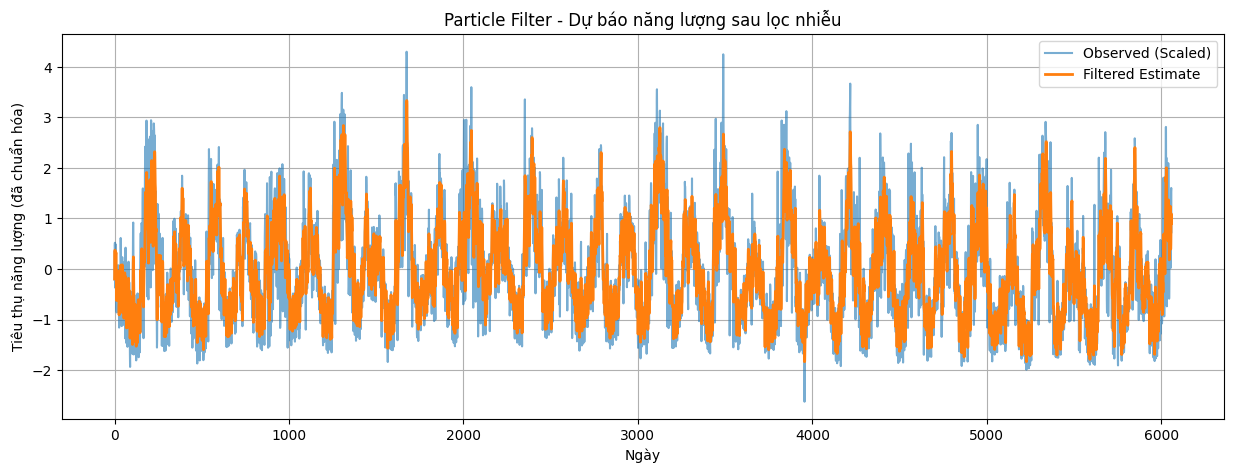

In [58]:
import numpy as np
import matplotlib.pyplot as plt


class ParticleFilter:
    def __init__(self, n_particles, transition_func, obs_likelihood_func):
        self.n_particles = n_particles
        self.transition_func = transition_func
        self.obs_likelihood_func = obs_likelihood_func
        self.particles = None
        self.weights = None

    def initialize(self, init_state_range):
        self.particles = np.random.uniform(init_state_range[0], init_state_range[1], self.n_particles)
        self.weights = np.ones(self.n_particles) / self.n_particles

    def predict(self):
        self.particles = self.transition_func(self.particles)

    def update(self, observation):
        self.weights *= self.obs_likelihood_func(self.particles, observation)
        self.weights += 1e-300
        self.weights /= np.sum(self.weights)

    def resample(self):
        indices = np.random.choice(np.arange(self.n_particles), size=self.n_particles, p=self.weights)
        self.particles = self.particles[indices]
        self.weights = np.ones(self.n_particles) / self.n_particles

    def estimate(self):
        return np.average(self.particles, weights=self.weights)

def transition_func(particles):
    noise = np.random.normal(0, 0.1, size=particles.shape)
    return particles + noise

def observation_likelihood(particles, observation):
    return np.exp(-0.5 * ((observation - particles) ** 2) / 0.1**2)

observations = df_daily["Energy_Scaled"].values

pf = ParticleFilter(n_particles=500, transition_func=transition_func, obs_likelihood_func=observation_likelihood)
pf.initialize(init_state_range=[-2, 2])

estimates = []
for obs in observations:
    pf.predict()
    pf.update(obs)
    pf.resample()
    estimates.append(pf.estimate())

plt.figure(figsize=(15, 5))
plt.plot(observations, label="Observed (Scaled)", alpha=0.6)
plt.plot(estimates, label="Filtered Estimate", linewidth=2)
plt.legend()
plt.title("Particle Filter - Dự báo năng lượng sau lọc nhiễu")
plt.xlabel("Ngày")
plt.ylabel("Tiêu thụ năng lượng (đã chuẩn hóa)")
plt.grid(True)
plt.show()
